In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import json
import sys
# setting path
sys.path.append('../common')
import utils

SETUP_PATH = 'setup.json'
f = open(SETUP_PATH)
data = json.load(f)

In [2]:
# Initialize database
import requests
import datetime

clear_url = data['app']['clearUrl']
print(clear_url)
response = requests.post(clear_url)
print(response.content)
print(response.status_code)

fill_in_url = data['app']['fillInUrl']
N = data['fill_in_quantity']
print(fill_in_url)
print(N)
patch = 10000
iterations = int(N / patch)
print(iterations)
for i in range(1, iterations + 1):
    first_time = datetime.datetime.now()
    response = requests.post(fill_in_url, params={'N': patch})
    later_time = datetime.datetime.now()
    difference = later_time - first_time
    print(f'{i}/{iterations}: {response.content}')
    print(f'{i}/{iterations}: {response.status_code}')
    print(f'{i}/{iterations}: duration: {utils.durationToString(difference.seconds)}')
    remaining_iterations = iterations - i
    print(f'{i}/{iterations}: expected end in: {utils.durationToString(difference.seconds * remaining_iterations)}')

patch = N % patch
if patch > 0:
    response = requests.post(fill_in_url, params={'N': patch})
    print(response.content)
    print(response.status_code)

http://localhost:8000/blogs/clear/
b'{"Count of Blogs":0}'
200
http://localhost:8000/blogs/fill_in/
100000
10
1/10: b'{"Count of Blogs":10000}'
1/10: 200
1/10: duration: 26s
1/10: expected end in: 3m 54s
2/10: b'{"Count of Blogs":20000}'
2/10: 200
2/10: duration: 25s
2/10: expected end in: 3m 20s
3/10: b'{"Count of Blogs":30000}'
3/10: 200
3/10: duration: 25s
3/10: expected end in: 2m 55s
4/10: b'{"Count of Blogs":40000}'
4/10: 200
4/10: duration: 25s
4/10: expected end in: 2m 30s
5/10: b'{"Count of Blogs":50000}'
5/10: 200
5/10: duration: 25s
5/10: expected end in: 2m 5s
6/10: b'{"Count of Blogs":60000}'
6/10: 200
6/10: duration: 26s
6/10: expected end in: 1m 44s
7/10: b'<html>\r\n<head><title>502 Bad Gateway</title></head>\r\n<body>\r\n<center><h1>502 Bad Gateway</h1></center>\r\n<hr><center>nginx/1.25.3</center>\r\n</body>\r\n</html>\r\n'
7/10: 502
7/10: duration: 30s
7/10: expected end in: 1m 30s
8/10: b'{"Count of Blogs":76654}'
8/10: 200
8/10: duration: 29s
8/10: expected end in:

In [3]:
def run_k6(app: dict, script_path: str, vus: int, dir_name):
    !k6 run {script_path} \
        --env vus={vus} \
        --env url={app["url"]} \
        --out json={dir_name}/{app["name"]}.json \
        --out csv={dir_name}/{app["name"]}.csv

## Run k6 test script

In [16]:
import os
import shutil
from datetime import datetime
import math 



# prepare directory structure
if not os.path.exists(data["test_result_base_dir"]):
    os.makedirs(data["test_result_base_dir"])

dt_string = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
print("date and time =", dt_string)

dir_name = f'./{data["test_result_base_dir"]}/{data["test_result_dir_prefix"]}{dt_string}'
print(dir_name)
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
    
# copy script
shutil.copy(data["script_path"], dir_name)
shutil.copy(SETUP_PATH, dir_name)

out_file_name = "out-fill-in.txt"
out_file = open(out_file_name, "a")
out_file.write(f'\n-------------------------')
out_file.close()

vus = 2048 # initial value
beg = 1
end = None
threshold = 0
while (True):
    # run test
    run_k6(data["app"], script_path=data["script_path"], vus=vus, dir_name=dir_name)

    # load dataframe
    dir = utils.get_last_result_dir(setup_data=data)
    path = f'./{dir}/{data["app"]["name"]}.csv'
    df = pd.read_csv(path)

    # calculate metric
    incorrect_part = utils.get_incorrect_part(df)
        
    print(f'Incorrect part for vus = {vus}: {incorrect_part}\n')

    out_file = open(out_file_name, "a")
    out_file.write(f'\nvus = {vus}, beg = {beg}, end = {end}, incorrect_part = {incorrect_part}')
    out_file.close()

    if (incorrect_part > threshold):
        end = vus
        vus = math.floor((end + beg) / 2)
    else:
        beg = vus
        vus = vus * 2 if end == None else math.floor((end + beg) / 2)
    
    if end and end - beg < 2:
        break
        


date and time = 2023-11-04_22-23-18
./out/out_2023-11-04_22-23-18

          /\      |‾‾| /‾‾/   /‾‾/   
     /\  /  \     |  |/  /   /  /    
    /  \/    \    |     (   /   ‾‾\  
   /          \   |  |\  \ |  (‾)  | 
  / __________ \  |__| \__\ \_____/ .io

  execution: local
     script: ../../grafana-k6/script.js
     output: json (./out/out_2023-11-04_22-23-18/django.json), csv (./out/out_2023-11-04_22-23-18/django.csv)

  scenarios: (100.00%) 1 scenario, 2048 max VUs, 1m0s max duration (incl. graceful stop):
           * default: 2048 looping VUs for 30s (gracefulStop: 30s)


Init      [====>---------------------------------] 0317/2048 VUs initialized
default   [--------------------------------------]

Init      [=========>----------------------------] 0550/2048 VUs initialized
default   [--------------------------------------]

Init      [===============>----------------------] 0867/2048 VUs initialized
default   [--------------------------------------]

Init      [=============

/tmp/ipykernel_44591/839792683.py:40: DtypeWarning: Columns (4,6,8,9,10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Incorrect part for vus = 4096: 0.44143426294820715


          /\      |‾‾| /‾‾/   /‾‾/   
     /\  /  \     |  |/  /   /  /    
    /  \/    \    |     (   /   ‾‾\  
   /          \   |  |\  \ |  (‾)  | 
  / __________ \  |__| \__\ \_____/ .io

  execution: local
     script: ../../grafana-k6/script.js
     output: json (./out/out_2023-11-04_22-23-18/django.json), csv (./out/out_2023-11-04_22-23-18/django.csv)

  scenarios: (100.00%) 1 scenario, 3072 max VUs, 1m0s max duration (incl. graceful stop):
           * default: 3072 looping VUs for 30s (gracefulStop: 30s)


Init      [=>------------------------------------] 0167/3072 VUs initialized
default   [--------------------------------------]

Init      [====>---------------------------------] 0465/3072 VUs initialized
default   [--------------------------------------]

Init      [======>-------------------------------] 0636/3072 VUs initialized
default   [--------------------------------------]

Init      [==========>----------------

/tmp/ipykernel_44591/839792683.py:40: DtypeWarning: Columns (6,8,9,10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Incorrect part for vus = 2816: 0.0


          /\      |‾‾| /‾‾/   /‾‾/   
     /\  /  \     |  |/  /   /  /    
    /  \/    \    |     (   /   ‾‾\  
   /          \   |  |\  \ |  (‾)  | 
  / __________ \  |__| \__\ \_____/ .io

  execution: local
     script: ../../grafana-k6/script.js
     output: json (./out/out_2023-11-04_22-23-18/django.json), csv (./out/out_2023-11-04_22-23-18/django.csv)

  scenarios: (100.00%) 1 scenario, 2944 max VUs, 1m0s max duration (incl. graceful stop):
           * default: 2944 looping VUs for 30s (gracefulStop: 30s)


Init      [===>----------------------------------] 0327/2944 VUs initialized
default   [--------------------------------------]

Init      [======>-------------------------------] 0568/2944 VUs initialized
default   [--------------------------------------]

Init      [===========>--------------------------] 0969/2944 VUs initialized
default   [--------------------------------------]

Init      [==============>-----------------------] 117

/tmp/ipykernel_44591/839792683.py:40: DtypeWarning: Columns (6,8,9,10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Incorrect part for vus = 3040: 0.0


          /\      |‾‾| /‾‾/   /‾‾/   
     /\  /  \     |  |/  /   /  /    
    /  \/    \    |     (   /   ‾‾\  
   /          \   |  |\  \ |  (‾)  | 
  / __________ \  |__| \__\ \_____/ .io

  execution: local
     script: ../../grafana-k6/script.js
     output: json (./out/out_2023-11-04_22-23-18/django.json), csv (./out/out_2023-11-04_22-23-18/django.csv)

  scenarios: (100.00%) 1 scenario, 3056 max VUs, 1m0s max duration (incl. graceful stop):
           * default: 3056 looping VUs for 30s (gracefulStop: 30s)


Init      [==>-----------------------------------] 0281/3056 VUs initialized
default   [--------------------------------------]

Init      [=====>--------------------------------] 0561/3056 VUs initialized
default   [--------------------------------------]

Init      [==========>---------------------------] 0900/3056 VUs initialized
default   [--------------------------------------]

Init      [=============>------------------------] 112

/tmp/ipykernel_44591/839792683.py:40: DtypeWarning: Columns (6,8,9,10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Incorrect part for vus = 3068: 0.0


          /\      |‾‾| /‾‾/   /‾‾/   
     /\  /  \     |  |/  /   /  /    
    /  \/    \    |     (   /   ‾‾\  
   /          \   |  |\  \ |  (‾)  | 
  / __________ \  |__| \__\ \_____/ .io

  execution: local
     script: ../../grafana-k6/script.js
     output: json (./out/out_2023-11-04_22-23-18/django.json), csv (./out/out_2023-11-04_22-23-18/django.csv)

  scenarios: (100.00%) 1 scenario, 3070 max VUs, 1m0s max duration (incl. graceful stop):
           * default: 3070 looping VUs for 30s (gracefulStop: 30s)


Init      [==>-----------------------------------] 0300/3070 VUs initialized
default   [--------------------------------------]

Init      [======>-------------------------------] 0571/3070 VUs initialized
default   [--------------------------------------]

Init      [===========>--------------------------] 1018/3070 VUs initialized
default   [--------------------------------------]

Init      [==============>-----------------------] 125

/tmp/ipykernel_44591/839792683.py:40: DtypeWarning: Columns (6,8,9,10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Incorrect part for vus = 3070: 0.0


          /\      |‾‾| /‾‾/   /‾‾/   
     /\  /  \     |  |/  /   /  /    
    /  \/    \    |     (   /   ‾‾\  
   /          \   |  |\  \ |  (‾)  | 
  / __________ \  |__| \__\ \_____/ .io

  execution: local
     script: ../../grafana-k6/script.js
     output: json (./out/out_2023-11-04_22-23-18/django.json), csv (./out/out_2023-11-04_22-23-18/django.csv)

  scenarios: (100.00%) 1 scenario, 3071 max VUs, 1m0s max duration (incl. graceful stop):
           * default: 3071 looping VUs for 30s (gracefulStop: 30s)


Init      [=>------------------------------------] 0235/3071 VUs initialized
default   [--------------------------------------]

Init      [======>-------------------------------] 0585/3071 VUs initialized
default   [--------------------------------------]

Init      [===========>--------------------------] 0986/3071 VUs initialized
default   [--------------------------------------]

Init      [==============>-----------------------] 127

## Smoke Processing data

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np

In [6]:
import sys
# setting path
sys.path.append('../common')
import utils


dir = utils.get_last_result_dir(setup_data=data)
print(dir)
path = f'.{data["test_result_base_dir"]}/{dir}/django.json'
print(path)
df = pd.read_csv(f'{dir}/django.csv')


out/out_2023-11-04_20-58-00
.out/out/out_2023-11-04_20-58-00/django.json


In [7]:
path = f'./{dir}/{data["app"]["name"]}.csv'
df = pd.read_csv(path)

In [8]:
df.head()

,metric_name,timestamp,metric_value,check,error,error_code,expected_response,group,method,name,proto,scenario,service,status,subproto,tls_version,url,extra_tags,metadata
0,vus,1699128682,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,vus_max,1699128682,2770.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,vus,1699128683,2909.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,vus_max,1699128683,2909.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,vus,1699128684,2909.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35379 entries, 0 to 35378
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   metric_name        35379 non-null  object 
 1   timestamp          35379 non-null  int64  
 2   metric_value       35379 non-null  float64
 3   check              0 non-null      float64
 4   error              0 non-null      float64
 5   error_code         0 non-null      float64
 6   expected_response  22869 non-null  object 
 7   group              0 non-null      float64
 8   method             22869 non-null  object 
 9   name               22869 non-null  object 
 10  proto              22869 non-null  object 
 11  scenario           35257 non-null  object 
 12  service            0 non-null      float64
 13  status             22869 non-null  float64
 14  subproto           0 non-null      float64
 15  tls_version        0 non-null      float64
 16  url                228

In [10]:
df['metric_name'].unique()

array(['vus', 'vus_max', 'http_reqs', 'http_req_duration',
       'http_req_blocked', 'http_req_connecting',
       'http_req_tls_handshaking', 'http_req_sending', 'http_req_waiting',
       'http_req_receiving', 'http_req_failed', 'data_sent',
       'data_received', 'iteration_duration', 'iterations'], dtype=object)

[Text(0, 0, '61'),
 Text(0, 0, '61'),
 Text(0, 0, '2541'),
 Text(0, 0, '2541'),
 Text(0, 0, '2541'),
 Text(0, 0, '2541'),
 Text(0, 0, '2541'),
 Text(0, 0, '2541'),
 Text(0, 0, '2541'),
 Text(0, 0, '2541'),
 Text(0, 0, '2541'),
 Text(0, 0, '3711'),
 Text(0, 0, '3711'),
 Text(0, 0, '2483'),
 Text(0, 0, '2483')]

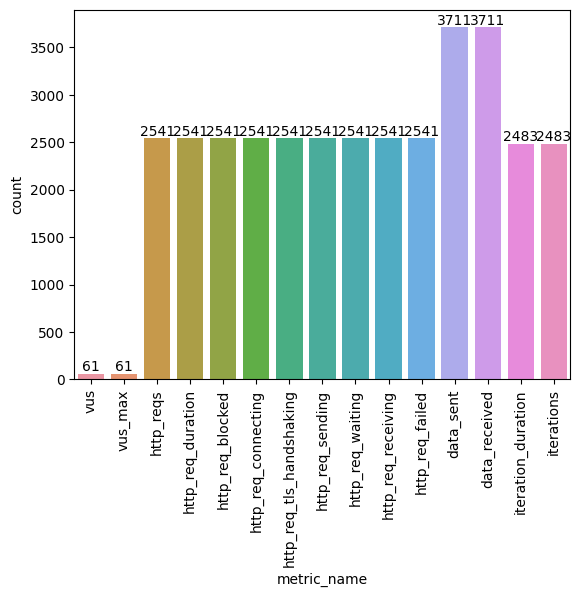

In [11]:
chart = sns.countplot(data=df, x='metric_name')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
chart.bar_label(chart.containers[0])


In [12]:
df.shape

(35379, 19)

In [13]:
df_1 = df.loc[(df['metric_name'] == 'http_req_duration')]
df_1.shape


(2541, 19)

In [14]:
df_1.head()

,metric_name,timestamp,metric_value,check,error,error_code,expected_response,group,method,name,proto,scenario,service,status,subproto,tls_version,url,extra_tags,metadata
31,http_req_duration,1699128697,14758.601933,NaN,NaN,NaN,True,NaN,GET,http://localhost:8000/collisions/,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://localhost:8000/collisions/,NaN,NaN
40,http_req_duration,1699128697,14775.047734,NaN,NaN,NaN,True,NaN,GET,http://localhost:8000/collisions/,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://localhost:8000/collisions/,NaN,NaN
49,http_req_duration,1699128697,14792.960188,NaN,NaN,NaN,True,NaN,GET,http://localhost:8000/collisions/,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://localhost:8000/collisions/,NaN,NaN
58,http_req_duration,1699128697,14808.980146,NaN,NaN,NaN,True,NaN,GET,http://localhost:8000/collisions/,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://localhost:8000/collisions/,NaN,NaN
67,http_req_duration,1699128697,14824.513916,NaN,NaN,NaN,True,NaN,GET,http://localhost:8000/collisions/,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://localhost:8000/collisions/,NaN,NaN
